In [1]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
!unzip -q Corona_Detection-master.zip -d .
!mv Corona_Detection-master/* .
!ls -a Corona_Detection-master
!rm -rf Corona_Detection-master

.  ..  .github	.gitignore


In [3]:
!python data.py

 98% 1.17G/1.19G [00:11<00:00, 106MB/s] 
100% 1.19G/1.19G [00:11<00:00, 107MB/s]
Starting Extraction
Linux
Extraction Complete
Reading Metadata
Starting Preprocessing and Moving According to Labels...
Cropping Successfull for person1632_virus_2827.jpegMoving Complete
Cleaning Complete


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [25]:
print("Summary of Dataset :- ")
summary = pd.read_csv('./data/Chest_xray_Corona_dataset_Summary.csv')
summary

Summary of Dataset :- 


,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


In [26]:
print("Metadata of Dataset :- ")
metadata = pd.read_csv('./data/Chest_xray_Corona_Metadata.csv')
metadata

Metadata of Dataset :- 


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


array(['Normal', 'Pnemonia'], dtype=object)

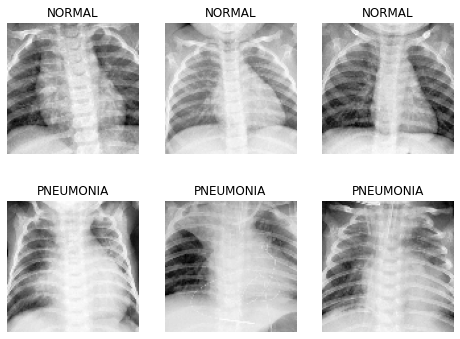

(234, 390)

In [27]:
normal_imgs = [fn for fn in os.listdir(f'/content/data/Corona_Classification_data/test/NORMAL') if fn.endswith('.jpeg')]
pneumo_imgs = [fn for fn in os.listdir(f'/content/data/Corona_Classification_data/test/INFECTED') if fn.endswith('.jpeg')]

# randomly select 3 of each
select_norm = np.random.choice(normal_imgs, 3, replace = False)
select_pneu = np.random.choice(pneumo_imgs, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (8,6))
for i in range(6):
    if i < 3:
        fp = f'/content/data/Corona_Classification_data/test/NORMAL/{select_norm[i]}'
        label = 'NORMAL'
    else:
        fp = f'/content/data/Corona_Classification_data/test/INFECTED/{select_pneu[i-3]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (100,100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
len(normal_imgs), len(pneumo_imgs)

In [28]:

# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
normal_images = img2np(f'/content/data/Corona_Classification_data/test/NORMAL/', normal_imgs)
pnemonia_images = img2np(f'/content/data/Corona_Classification_data/test/INFECTED/', pneumo_imgs)

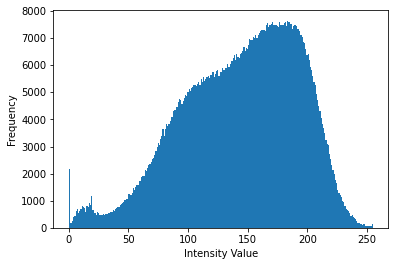

In [41]:
ax = plt.hist(normal_images.ravel(), bins = 256)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

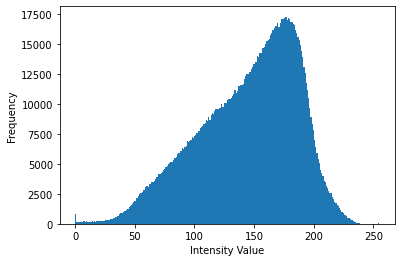

In [42]:
ax = plt.hist(pnemonia_images.ravel(), bins = 256)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

# Average Image
We can see from the average image that pneumonia X-rays tend to show higher obstruction around the chest area.

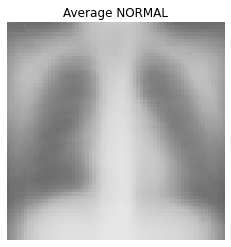

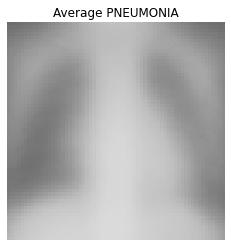

In [29]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pnemonia_images, 'PNEUMONIA')

## Contrast Between Average Images
Using the average images, we can also compute the difference.

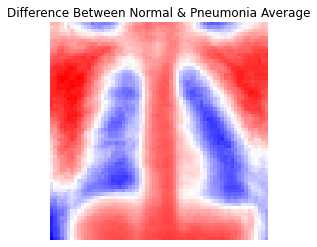

In [30]:
contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.show()

# Eigenimages

 **Principal** component analysis (PCA) to visualize the components that describe each class the best. 

Number of PC:  16


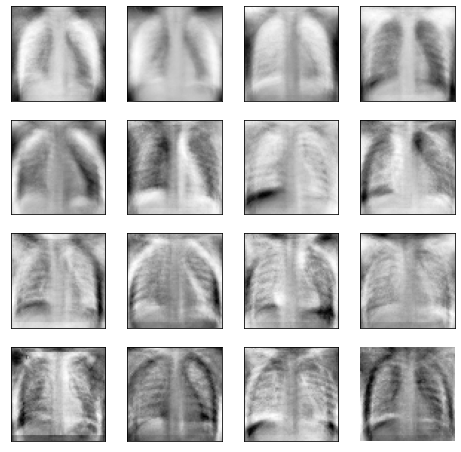

Number of PC:  11


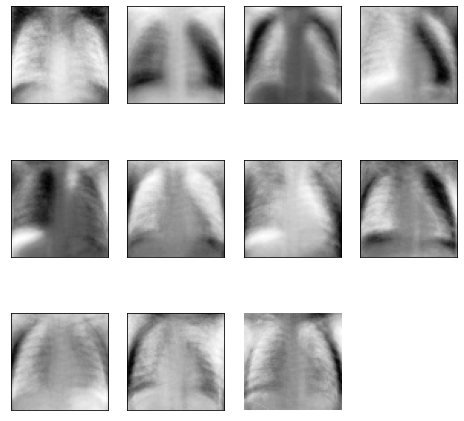

In [31]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (64, 64)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(normal_images, 'NORMAL'))
plot_pca(eigenimages(pnemonia_images, 'PNEUMONIA'))